In [4]:
import os

In [5]:
#!pip install mxnet tqdm opencv-python

In [6]:
import torch
from torch import nn

In [7]:
#!apt-get install aria2 || apt-get upgrade aria2
#!aria2c -x 16 https://www.dropbox.com/s/wpx6tqjf0y5mf6r/faces_ms1m-refine-v2_112x112.zip?dl=1

In [8]:
# !unzip '../data/faces_ms1m-refine-v2_112x112.zip' && rm '../data/faces_ms1m-refine-v2_112x112.zip'
#!unzip -d '../data/' '../data/faces_ms1m-refine-v2_112x112.zip'

In [9]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'insightface': 'https://github.com/foamliu/InsightFace-v3/releases/download/v1.0/insight-face-v3.pt',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

In [10]:
import torch.utils.model_zoo as model_zoo

In [11]:
# def conv3x3(in_planes, out_planes, stride=1):
#     """3x3 convolution with padding"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
#                      padding=1, bias=False)


# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, inplanes, planes, stride=1, downsample=None):
#         super(BasicBlock, self).__init__()
#         self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         residual = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             residual = self.downsample(x)

#         out += residual
#         out = self.relu(out)

#         return out


# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, inplanes, planes, stride=1, downsample=None,  use_se=None):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
#                                padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(planes * 4)
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         residual = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)

#         out = self.conv3(out)
#         out = self.bn3(out)

#         if self.downsample is not None:
#             residual = self.downsample(x)

#         out += residual
#         out = self.relu(out)

#         return out

# class SEBlock(nn.Module):
#     def __init__(self, channel, reduction=16):
#         super(SEBlock, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(channel, channel // reduction),
#             nn.PReLU(),
#             nn.Linear(channel // reduction, channel),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         y = self.avg_pool(x).view(b, c)
#         y = self.fc(y).view(b, c, 1, 1)
#         return x * y


# class IRBlock(nn.Module):
#     expansion = 1

#     def __init__(self, inplanes, planes, stride=1, downsample=None, **kwargs):
#         super(IRBlock, self).__init__()
#         self.bn0 = nn.BatchNorm2d(inplanes)
#         self.conv1 = conv3x3(inplanes, inplanes)
#         self.bn1 = nn.BatchNorm2d(inplanes)
#         self.prelu = nn.PReLU()
#         self.conv2 = conv3x3(inplanes, planes, stride)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.downsample = downsample
#         self.stride = stride
#         self.use_se = use_se
#         if self.use_se:
#             self.se = SEBlock(planes)

#     def forward(self, x):
#         residual = x
#         out = self.bn0(x)
#         out = self.conv1(out)
#         out = self.bn1(out)
#         out = self.prelu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         if self.use_se:
#             out = self.se(out)

#         if self.downsample is not None:
#             residual = self.downsample(x)

#         out += residual
#         out = self.prelu(out)

#         return out



# class ResNet(nn.Module):

#     def __init__(self, block, layers, use_se=True, im_size=112):
#         self.use_se = use_se
#         super(ResNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, (7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         # self.prelu = nn.PReLU(64)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
#         self.layer1, inplanes = self._make_layer(block, 64, 64, layers[0])
#         self.layer2, inplanes = self._make_layer(block, inplanes, 128, layers[1], stride=2)
#         self.layer3, inplanes = self._make_layer(block, inplanes, 256, layers[2], stride=2)
#         self.layer4, inplanes = self._make_layer(block, inplanes, 512, layers[3], stride=2)
#         # self.bn2 = nn.BatchNorm2d(inplanes)
#         # self.dropout = nn.Dropout()
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

#         if im_size == 112:
#             self.fc = nn.Linear(inplanes, 1000)
#         else:  # 224
#             self.fc = nn.Linear(inplanes * 2, 1000)
#         # self.bn3 = nn.BatchNorm1d(1000)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.xavier_normal_(m.weight)
#             elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight)
#                 nn.init.constant_(m.bias, 0)

#     def _make_layer(self, block, inplanes, planes, blocks, stride=1):
#         downsample = None
#         print(inplanes, planes)
#         if stride != 1 or inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(inplanes, planes * block.expansion,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(inplanes, planes, stride, downsample, use_se=self.use_se))
#         out = planes * block.expansion
#         for i in range(1, blocks):
#             layers.append(block(out, planes, use_se=self.use_se))

#         return nn.Sequential(*layers), out

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         # x = self.prelu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         # x = self.bn2(x)
#         # x = self.dropout(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         # x = self.fc(x)
#         # x = self.bn3(x)

#         return x


In [12]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.PReLU(),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class IRBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_se=True):
        super(IRBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes)

    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_se:
            out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.prelu(out)

        return out
class ResNet(nn.Module):

    def __init__(self, block, layers, use_se=True, im_size=112):
        self.inplanes = 64
        self.use_se = use_se
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.bn2 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()

        if im_size == 112:
            self.fc = nn.Linear(512 * 7 * 7, 512)
        else:  # 224
            self.fc = nn.Linear(512 * 14 * 14, 512)
        self.bn3 = nn.BatchNorm1d(512)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_se=self.use_se))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_se=self.use_se))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.bn2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.bn3(x)

        return x


In [13]:
def resnet18(args, BaseNet=ResNet, **kwargs):
    model = BaseNet(IRBlock, [2, 2, 2, 2], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(args, BaseNet=ResNet, **kwargs):
    model = ReBaseNetsNet(IRBlock, [3, 4, 6, 3], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(args, BaseNet=ResNet, **kwargs):
    model = BaseNet(IRBlock, [3, 4, 6, 3], use_se=args.use_se, im_size=args.im_size, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(args, BaseNet=ResNet, Block=IRBlock, **kwargs):
    model = BaseNet(IRBlock, [3, 4, 23, 3], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(args, BaseNet=ResNet, **kwargs):
    model = ResNet(IRBlock, [3, 8, 36, 3], use_se=args.use_se, **kwargs)
    if args.pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [14]:

import torch

# setting device on GPU if available, else CPU
print(torch.cuda.is_available())

True


In [15]:
import sys
import os
# sys.path.append('..')
# sys.path.append(os.path.abspath('insightface'))
# sys.path

In [16]:
# from insightface.extract import extract

In [17]:
import os
import pickle

import cv2 as cv
import mxnet as mx
from tqdm import tqdm
from mxnet import recordio, io

# from insightface.utils import ensure_folder

In [18]:
import argparse
def parse_args():
    parser = argparse.ArgumentParser(description='Train face network')
    # general
    parser.add_argument('--pretrained', type=bool, default=True, help='pretrained model')
    parser.add_argument('--network', default='r101', help='specify network')
    parser.add_argument('--end-epoch', type=int, default=1000, help='training epoch size.')
    parser.add_argument('--lr', type=float, default=0.1, help='start learning rate')
    parser.add_argument('--lr-step', type=int, default=10, help='period of learning rate decay')
    parser.add_argument('--optimizer', default='sgd', help='optimizer')
    parser.add_argument('--weight-decay', type=float, default=5e-4, help='weight decay')
    parser.add_argument('--mom', type=float, default=0.9, help='momentum')
    parser.add_argument('--emb-size', type=int, default=512, help='embedding length')
    parser.add_argument('--batch-size', type=int, default=512, help='batch size in each context')
    parser.add_argument('--margin-m', type=float, default=0.5, help='angular margin m')
    parser.add_argument('--margin-s', type=float, default=64.0, help='feature scale s')
    parser.add_argument('--easy-margin', type=bool, default=False, help='easy margin')
    parser.add_argument('--focal-loss', type=bool, default=False, help='focal loss')
    parser.add_argument('--gamma', type=float, default=2.0, help='focusing parameter gamma')
    parser.add_argument('--use-se', type=bool, default=True, help='use SEBlock')
    parser.add_argument('--full-log', type=bool, default=False, help='full logging')
    parser.add_argument('--checkpoint', type=str, default=None, help='checkpoint')
    args = parser.parse_args([])
    return args

In [19]:
import torchvision

In [20]:
class Args:
  pretrained = False
  use_se = True
  # emb_size = 512
  # batch_size = 256
  # im_size = 112

In [21]:
# model = torchvision.models.resnet101()
# print(model.forward)

In [22]:
args = Args()
print(args)
# model = torch.utils.model_zoo.load_url(model_urls['resnet101'])
# model = torchvision.models.resnet101()
# model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
model = resnet101(args)
print(model.forward)

<bound method ResNet.forward of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu): PReLU(num_parameters=1)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): IRBlock(
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_featu

In [23]:
args = Args()
model = resnet101(args)
model.load_state_dict(model_zoo.load_url(model_urls['insightface'], map_location=torch.device('cpu')))

<All keys matched successfully>

In [24]:

from torch.autograd import Variable
import numpy as np

In [25]:
from torchvision import transforms

In [26]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.125, contrast=0.125, saturation=0.125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [27]:
device = torch.device('cuda:1')
torch.cuda.empty_cache()
# device = xm.xla_device()
# model.cuda()
model = model.to(device)
model.float()
model.eval()
model.requires_grad_(False)
pass
# arcface = ArcMarginModel(args).to(device).eval()

In [28]:
from sklearn.cluster import MiniBatchKMeans

In [29]:
faces_ms1m_folder = '../data/faces_emore'
path_imgidx = os.path.join(faces_ms1m_folder, 'train.idx')
path_imgrec = os.path.join(faces_ms1m_folder, 'train.rec')

In [30]:
imgrec = recordio.MXIndexedRecordIO(os.path.abspath(path_imgidx), os.path.abspath(path_imgrec), 'r')
imgrec_batched = io.ImageRecordIter(path_imgidx=os.path.abspath(path_imgidx), path_imgrec=os.path.abspath(path_imgrec), data_shape=(3, 112, 112), batch_size=512)

# class_ids = set()
# i = 0

# while True:
#     try:
#         index = i + 1
#         header, _ = recordio.unpack(imgrec.read_idx(i + 1))
#         # print(header.label)
#         # print(type(header.label))
#         label = int(header.label)
#         class_ids.add(label)
#         if index % 10000 == 0:
#             print(index, len(class_ids))
#         i += 1
#     except:
#         break

In [31]:
batch = imgrec_batched.next()

In [32]:
imgrec_batched.next()

In [33]:
imgrec_batched.iter_next()

1

In [34]:
from PIL import Image, ImageOps

In [35]:
def l2_norm(input):
    norm = torch.norm(input, 2, keepdim=True)
    output = torch.div(input, norm)
    return output


In [36]:
def get_features(images, model, transform, flip=True):
    length = len(images)
    embedding = torch.zeros([length, 3, 112, 112], dtype=torch.float, device=device)
    embedding_flipped = torch.zeros([length, 3, 112, 112], dtype=torch.float, device=device)

    for idx, image in enumerate(images):
        image = np.reshape(image, (112, 112, 3))
        image = Image.fromarray(image)
        flipped = ImageOps.flip(image)
        image = transform(image).to(device)
        embedding[idx] = image


    flipped = transform(flipped).to(device)
    embedding_flipped[idx] = flipped

    features = model(embedding)

    if not flip:
        return features

    features_fplipped = model(embedding_flipped) 
    result = torch.zeros((length, np.shape(features)[-1]), device=device)

    for idx in range(length):
        result[idx] = l2_norm(features[idx] + features_fplipped[idx])


    return result


In [37]:
kmeans = MiniBatchKMeans(n_clusters=128, random_state=0, compute_labels=True)

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
def new_euclidean_distances(X, Y=None, Y_norm_squared=None, squared=False): 
    return cosine_similarity(X,Y)

# monkey patch (ensure cosine dist function is used)
from sklearn.cluster import k_means_
k_means_.euclidean_distances = new_euclidean_distances

/home/a.y.igoshin/virtual_environments/main/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [39]:
class ArcMarginModel(nn.Module):
    def __init__(self, args):
        super(ArcMarginModel, self).__init__()

        self.weight = Parameter(torch.FloatTensor(num_classes, args.emb_size))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = args.easy_margin
        self.m = args.margin_m
        self.s = args.margin_s

        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m

    def forward(self, input, label):
        x = F.normalize(input)
        W = F.normalize(self.weight)
        cosine = F.linear(x, W)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(theta + m)
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [40]:
import pandas as pd

In [41]:
def generate_embeddings(file_path, start=0):
    i = 0
    batch_size = 512
#     result = []
    
#     try:
#         df = pd.read_csv(file_path)
#         start = len(df)
#     except Exception as e:
#         print(e)
#         df = pd.DataFrame.from_records([], columns=['image', 'label'])
#         df.to_csv(file_path, index=False)
#         pass

    imgrec_batched.reset()

    with torch.no_grad():
        while imgrec_batched.iter_next():
            try:
                if i * batch_size < start:
                    i += 1
                    if i % 100 == 0:
                        print(i * batch_size) 
                    continue
                images = imgrec_batched.getdata().asnumpy().astype(np.uint8)
                labels = imgrec_batched.getlabel().asnumpy()
                features = get_features(images, model, data_transforms['val'])
                features = features.cpu().numpy()
                data = list(zip(features, labels))
                df = pd.DataFrame.from_records(data, columns=['image', 'label'])
                df.to_csv(file_path, index=False, header=False, mode='a')
    #             result.extend(data)
    #             np.save(file_path, result)

                i += 1
                print(i * batch_size) 
            except Exception as e:
                print(e)
                return

In [ ]:
embeddings_file = '../data/embeddings.csv'
generate_embeddings(embeddings_file, 5813760)

51200
102400
153600
204800
256000
307200
358400
409600
460800
512000
563200
614400
665600
716800
768000
819200
870400
921600
972800
1024000
1075200
1126400
1177600
1228800
1280000
1331200
1382400
1433600
1484800
1536000
1587200
1638400
1689600
1740800
1792000
1843200
1894400
1945600
1996800
2048000
2099200
2150400
2201600
2252800
2304000
2355200
2406400
2457600
2508800
2560000
2611200
2662400
2713600
2764800
2816000
2867200
2918400
2969600
3020800
3072000
3123200
3174400
3225600
3276800
3328000
3379200
3430400
3481600
3532800
3584000
3635200
3686400
3737600
3788800
3840000
3891200
3942400
3993600
4044800
4096000
4147200
4198400
4249600
4300800
4352000
4403200
4454400
4505600
4556800
4608000
4659200
4710400
4761600
4812800
4864000
4915200
4966400
5017600
5068800
5120000
5171200
5222400
5273600
5324800
5376000
5427200
5478400
5529600
5580800
5632000
5683200
5734400
5785600


In [81]:
torch.cuda.device_count()

4

In [38]:
torch.cuda.memory_summary('cuda:3')

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 3                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  509510 KB |  509510 KB |  659891 KB |  150381 KB |\n|       from large pool |  501504 KB |  501504 KB |  501504 KB |       0 KB |\n|       from small pool |    8006 KB |    8006 KB |  158387 KB |  150381 KB |\n|---------------------------------------------------------------------------|\n| Active memory         |  509510 KB |  509510 KB |  659891 KB |  150381 KB |\n|       from large pool |  501504 KB |  501504 KB |

In [0]:
imgrec_batched.reset()
batch_size = 1024
i = 0
with torch.no_grad():
  while imgrec_batched.iter_next():
      try:
          images = imgrec_batched.getdata().asnumpy().astype(np.uint8)
          features = get_features(images, model, data_transforms['val'])
          kmeans.partial_fit(features / np.linalg.norm(features))
          i += 1
          print(i * batch_size)

          if (i * batch_size) > 1000:
              break;
      except Exception as e:
          print(e)
          break

can't convert xla:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


In [0]:
labels = []
buckets = dict()
imgrec_batched.reset()
batch_size = 1024
i = 0
with torch.no_grad():
  while imgrec_batched.iter_next():
      try:
          
          labels.extend(imgrec_batched.getlabel().asnumpy())
          images = imgrec_batched.getdata().asnumpy().astype(np.uint8)
          features = get_features(images, model, data_transforms['val'])
          ids = kmeans.predict(features / np.linalg.norm(features))
            
          for j, cluster in enumerate(ids):
              if buckets.get(cluster, None) is None:
                buckets.update({cluster: []})
              index = i * batch_size + j
              buckets[cluster].append(index)
              # print(index)
          
          i += 1

          print(i * batch_size)
          if (i * batch_size) > 10000:
              break;
      except Exception as e:
          print(e)
          break

In [0]:
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
len(labels)

In [0]:
# sum([len(bucket) for bucket in buckets])

In [0]:
# [len(bucket) for bucket in buckets]
for bucket in buckets:
  print(buckets[bucket])

True
145


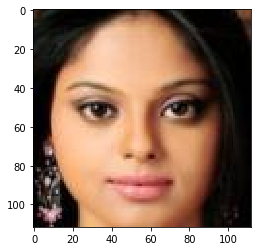

In [0]:
index = 10241
header, s = recordio.unpack(imgrec.read_idx(index + 1))
img = mx.image.imdecode(s).asnumpy()
label = int(header.label)
plt.figure()
plt.imshow(img)

print(label in labels)
print(int(header.label))

In [0]:
import torch.functional as F

In [0]:
from torch.utils.data import Dataset

class ArcFaceBucketsDataset(Dataset):

  def __init__(self, path_imgrec, path_imgidx, buckets):
    self.imgrec = recordio.MXIndexedRecordIO(os.path.abspath(path_imgidx), os.path.abspath(path_imgrec), 'r')
    self.indexes = [idx for i, bucket in enumerate(buckets) for j, idx in enumerate(bucket[i])]
  
  def __len__(self):
    return len(self.indexes)
  
  def __getitem__(self, idx):
    img_idx = self.indexes[idx]
    header, s = recordio.unpack(imgrec.read_idx(img_idx + 1))
    target = mx.image.imdecode(s).asnumpy()
    target = cv.cvtColor(target, cv.COLOR_RGB2BGR)

    return target


In [0]:
dataset = ArcFaceBucketsDataset(path_imgrec, path_imgidx, )

In [0]:
imgrec.reset()
def run():
  with torch.no_grad():

    header, s = recordio.unpack(imgrec.read_idx(index + 1))
    img = mx.image.imdecode(s).asnumpy()
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    label = int(header.label)
    features = get_features([img], model, data_transforms['val'], flip=True)
    distances_to_centers = 1 - nn.CosineSimilarity(dim=1).forward(features.cuda(), torch.tensor(kmeans.cluster_centers_).cuda())
    distances_to_centers = distances_to_centers.cpu().numpy()
    clusters_sorted = np.argsort()

    for cluster in clusters_sorted:
      batch = get_batch(imgrec, cluster, buckets)
      features = get_features(batch, model,data_transforms['val'], flip=True)
run()

tensor([0.8225, 0.7720, 0.8685, 0.8485, 0.8126, 0.8134, 0.7937, 0.8291, 0.8998,
        0.7873, 0.8063, 0.8159, 0.8847, 0.7846, 0.8733, 0.7996, 0.9215, 0.8346,
        0.8399, 0.7814, 0.7793, 0.7862, 0.9169, 0.8531, 0.7969, 0.8136, 0.8457,
        0.8311, 0.8275, 0.8375, 0.8528, 0.8918, 0.8133, 0.8474, 0.8553, 0.7963,
        0.8730, 0.8187, 0.8842, 0.8396, 0.8768, 0.8523, 0.8095, 0.8176, 0.8648,
        0.8770, 0.8416, 0.8409, 0.7945, 0.8205, 0.8073, 0.8764, 0.8897, 0.8401,
        0.9418, 0.8037, 0.8309, 0.8636, 0.8147, 0.8303, 0.8253, 0.8183, 0.8352,
        0.8970, 0.8707, 0.8267, 0.8435, 0.8576, 0.8115, 0.8176, 0.8267, 0.8855,
        0.9454, 0.8432, 0.8311, 0.8147, 0.8541, 0.9251, 0.7667, 0.8447, 0.8491,
        0.7865, 0.8355, 0.8077, 0.8837, 0.8477, 0.8371, 0.8867, 0.8205, 0.9057,
        0.8540, 0.8357, 0.8296, 0.8211, 0.8947, 0.8484, 0.8354, 0.8203, 0.7931,
        0.7676, 0.8101, 0.8438, 0.8592, 0.8302, 0.8634, 0.7987, 0.8555, 0.8707,
        0.8134, 0.8311, 0.7967, 0.8274, 

138
tensor([0.1666], device='cuda:0')
150
tensor([0.1079], device='cuda:0')
161
tensor([0.1789], device='cuda:0')
166
tensor([0.1069], device='cuda:0')
178
tensor([0.1740], device='cuda:0')
213
tensor([0.1109], device='cuda:0')
223
tensor([0.1226], device='cuda:0')
300
tensor([0.0971], device='cuda:0')
487
tensor([0.1606], device='cuda:0')
1847
tensor([0.2559], device='cuda:0')
1947
tensor([0.2084], device='cuda:0')
2003
tensor([0.1866], device='cuda:0')
2022
tensor([0.2403], device='cuda:0')
2023
tensor([0.2182], device='cuda:0')
2042
tensor([0.0601], device='cuda:0')
2056
tensor([0.1733], device='cuda:0')
2066
tensor([0.2017], device='cuda:0')
2068
tensor([0.1536], device='cuda:0')
2071
tensor([0.1472], device='cuda:0')
2079
tensor([0.1908], device='cuda:0')
2083
tensor([0.2539], device='cuda:0')
2088
tensor([0.1005], device='cuda:0')
2093
tensor([0.1565], device='cuda:0')
2181
tensor([0.1937], device='cuda:0')
2211
tensor([0.2366], device='cuda:0')
2226
tensor([0.1681], device='cuda

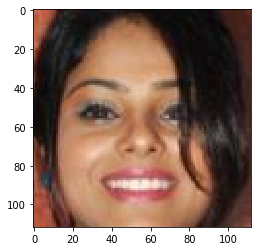

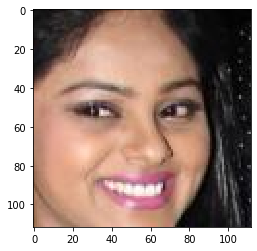

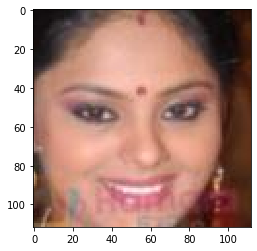

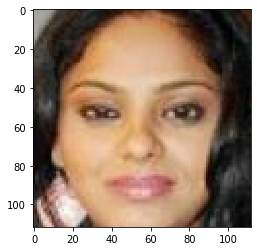

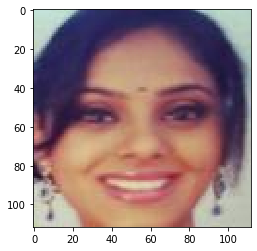

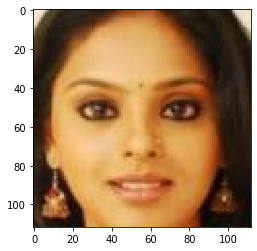

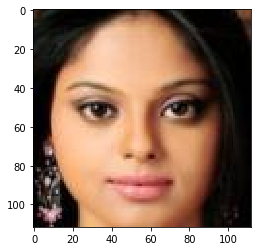

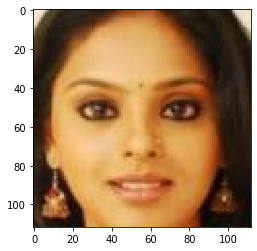

In [0]:
# i = 10000
imgrec.reset()
def run():
  with torch.no_grad():
    count = 0
    # index  = 1015
    header, s = recordio.unpack(imgrec.read_idx(index + 1))
    img = mx.image.imdecode(s).asnumpy()
    # print(img.shape)
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    # print(header.label)
    # print(type(header.label))
    label = int(header.label)
    # images.append(img)
    # labels.append(label)
    features = get_features([img], model, data_transforms['val'], flip=True)
    distances_to_centers = [cosine(features.cpu().numpy()[0], center) for center in kmeans.cluster_centers_]
    clusters_sorted = np.argsort(distances_to_centers)
    for cluster in clusters_sorted:
        for idx in buckets[cluster]:
            print(idx)
            count += 1
            header, s = recordio.unpack(imgrec.read_idx(idx + 1))
            target = mx.image.imdecode(s).asnumpy()
            target = cv.cvtColor(target, cv.COLOR_RGB2BGR)
#             print(img.shape)
            item = get_features([target], model,data_transforms['val'], flip=True)

            # item = torch.cat(item)
            # diff = item.cuda().unsqueeze(-1) - features.cuda().transpose(1, 0).unsqueeze(0)
            # dist = torch.sum(torch.pow(diff, 2), dim=1)
            if labels[idx] == label:
              print('Win!')
              plt.figure()
              plt.imshow(cv.cvtColor(target, cv.COLOR_BGR2RGB))
            # print(dist)
            print(nn.CosineSimilarity(dim=1).forward(features.cuda(), item.cuda()))
            if nn.CosineSimilarity(dim=1).forward(features.cuda(), item.cuda()) > 0.7:
            # if dist < 4:
                # print(1 - cosine(features, item))
                plt.figure()
                plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
                plt.figure()
                plt.imshow(cv.cvtColor(target, cv.COLOR_BGR2RGB))
                return labels[idx], label
    print(count)
print(run())
# print(count)

In [0]:
# for j in range(i, i + 10):
#     try:
#         index = j + 1
#         header, s = recordio.unpack(imgrec.read_idx(j+ 1))
#         img = mx.image.imdecode(s).asnumpy()
#         # print(img.shape)
#         img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
#         # print(header.label)
#         # print(type(header.label))
#         label = int(header.label)
#         images.append(img)
#         labels.append(label)
#         tensor = torch.FloatTensor(img).view(1, 3, 112, 112)
#         tensor = tensor.to(device)
#         result = model.forward(tensor)
#         distance_to_centers = cosine(result, cluster_centers_)
        
        
#         if (index - i) % batch_size == 0:
#             print(index)
#             print(np.shape(images))
#             tensor = torch.FloatTensor(images).view(batch_size, 3, 112, 112)
#             tensor = tensor.to(device)
#             result = model.forward(tensor)
#             print(np.shape(result))
#             distances_to_centers = [x for vec in result]
#             ids = kmeans.transform(result.detach().numpy())
            
#             for j, cluster in enumerate(ids):
#                 if buckets.get(cluster, None) is None:
#                     buckets.update({cluster: []})
#                 buckets[cluster].append(i - 256 + j)
#             labels = []
#             images = []
#         if i > 5000:
#             break
#         i += 1
#     except Exception as e:
#         print(e)
#         break

In [0]:
import math
math.cos(math.pi - args.margin_m)